In [132]:
import pandas as pd
import numpy as np
import math
from matplotlib.backends.backend_pdf import PdfPages
from functools import partial, reduce
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import os
import re
import glob

In [133]:
all_files = glob.glob('C:/Users/lzoeckler/Desktop/all_data/separated/binned/*.csv')
big_df = []
for file in all_files:
    df = pd.read_csv(file)
    big_df.append(df)
big_df = pd.concat(big_df, sort=True)
big_df = big_df.loc[~big_df['PCR_pos'].isnull()]
big_df.head()

,HRP2_deletion,PCR_pos,age_yrs,coinfection,country,febrile,infection_category,lat,long,microscopy_pos,...,quansys_LDH_Pf_result,quansys_LDH_Pv_bin,quansys_LDH_Pv_pg_ml,quansys_LDH_Pv_result,quansys_type,sample_id,sample_type,study_id,survey,timepoint_days
0,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 110501023 (),WB,16-SMRU-01,cross sectional ...,NaN
1,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421001 (),WB,16-SMRU-01,cross sectional ...,NaN
2,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421035 (),WB,16-SMRU-01,cross sectional ...,NaN
3,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 151019 (),WB,16-SMRU-01,cross sectional ...,NaN
4,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1771028 (),WB,16-SMRU-01,cross sectional ...,NaN


In [134]:
for study_id in big_df['study_id'].unique():
    study_df = big_df.loc[big_df['study_id'] == study_id]
    print(study_id, len(study_df))

16-SMRU-01 1822
17-NIH-01 620
17-NIH-02 327
17-QIMR-01 305
17-QIMR-02 163
17-QIMR-03 22
18-DLS-01 75
18-DLS-02 2
18-FIND-01 94
18-FIND-02 25


In [135]:
len(big_df)

3455

In [136]:
def clean_strings(val):
    if isinstance(val, str):
        if '<' in val:
            return np.log10(.1)
        elif '>' in val:
            clean = val.replace('> ', '')
            return np.log10(float(clean) + .1)
        else:
            try:
                return np.log10(float(val) + .1)
            except ValueError:
                return np.null
    elif isinstance(val, float) or isinstance(val, int):
        return np.log10(val + .1)
    else:
        raise

In [137]:
val_cols = ['quansys_HRP2_pg_ml', 'quansys_LDH_Pan_pg_ml', 'quansys_LDH_Pv_pg_ml',
            'quansys_LDH_Pf_pg_ml', 'quansys_CRP_ng_ml']

In [138]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
pos_df = pos_df.loc[~pos_df['quansys_LDH_Pv_pg_ml'].isnull()]
pos_df = pos_df.loc[~pos_df['quansys_HRP2_pg_ml'].isnull()]
pos_df[val_cols] = pos_df[val_cols].applymap(clean_strings)

In [119]:
den_df = pos_df.copy(deep=True)
den_df = den_df[val_cols + ['PCR_pos', 'sample_id']]

In [139]:
feb_df = pos_df.copy(deep=True)
feb_df = feb_df.loc[feb_df['febrile'] == 1]
feb_pf_df = feb_df.loc[feb_df['pf'] == 1]
feb_pv_df = feb_df.loc[feb_df['pv'] == 1]
feb_pf_df = feb_pf_df[val_cols + ['PCR_pos', 'sample_id']]
feb_pv_df = feb_pv_df[val_cols + ['PCR_pos', 'sample_id']]
feb_df = feb_df[val_cols + ['PCR_pos', 'sample_id']]

In [140]:
non_feb_df = pos_df.copy(deep=True)
non_feb_df = non_feb_df.loc[non_feb_df['febrile'] == 0]
non_feb_pf_df = non_feb_df.loc[non_feb_df['pf'] == 1]
non_feb_pv_df = non_feb_df.loc[non_feb_df['pv'] == 1]
non_feb_pf_df = non_feb_pf_df[val_cols + ['PCR_pos', 'sample_id']]
non_feb_pv_df = non_feb_pv_df[val_cols + ['PCR_pos', 'sample_id']]
non_feb_df = non_feb_df[val_cols + ['PCR_pos', 'sample_id']]

In [141]:
pf_df = pos_df.copy(deep=True)
pf_df = pf_df.loc[pf_df['pf'] == 1]
pf_df = pf_df[val_cols + ['PCR_pos', 'sample_id']]

In [142]:
pv_df = pos_df.copy(deep=True)
pv_df = pv_df.loc[pv_df['pv'] == 1]
pv_df = pv_df[val_cols + ['PCR_pos', 'sample_id']]

In [143]:
value_list = [(den_df, 'PCR+ pLDH', 'density_plot'), (feb_df, 'Febrile PCR+ pLDH', 'febrile_plot'),
              (feb_pf_df, 'Febrile Pf+ PCR+ pLDH', 'febrile_pf_plot'),
              (feb_pv_df, 'Febrile Pv+ PCR+ pLDH', 'febrile_pv_plot'),
              (non_feb_df, 'Non-febrile PCR+ pLDH', 'non_febrile_plot'),
              (non_feb_pf_df, 'Non-febrile Pf+ PCR+ pLDH', 'non_febrile_pf_plot'),
              (non_feb_pv_df, 'Non-febrile Pv+ PCR+ pLDH', 'non_febrile_pv_plot'),
              (pf_df, 'Pf+ PCR+ pLDH', 'pf_plot'), (pv_df, 'Pv+ PCR+ pLDH', 'pv_plot')]

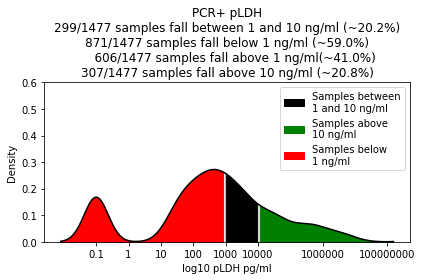

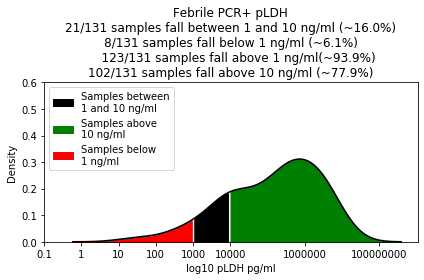

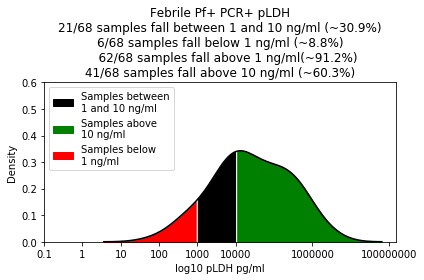

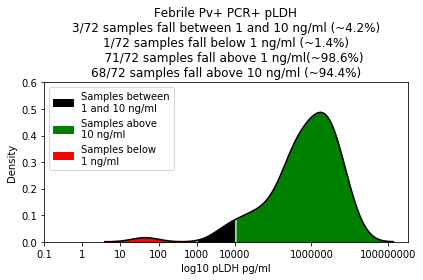

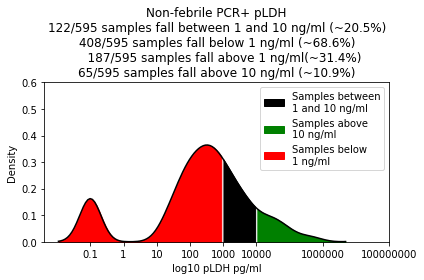

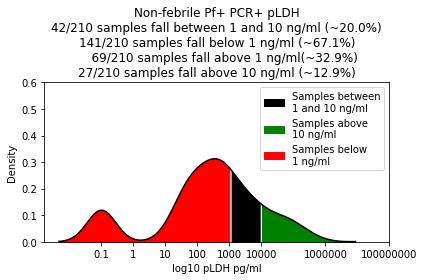

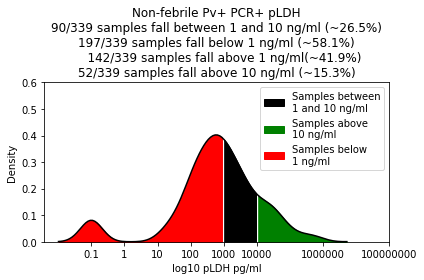

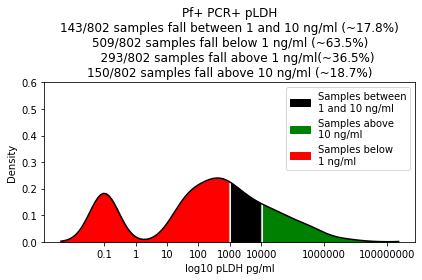

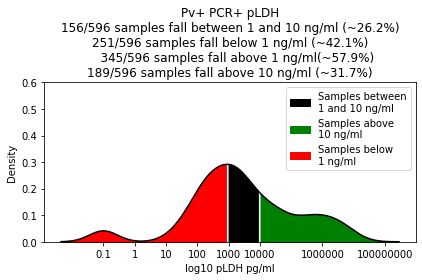

In [145]:
for test_df, pdf_title, plot_title in value_list:
    x = test_df['quansys_LDH_Pan_pg_ml'].values
    
    sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
    sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(10000)]
    sub_samps = sub['sample_id'].values
    sub = len(sub)
    below = len(test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)])
    above = len(test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)])
    ten_above = len(test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(10000)])
    total = len(test_df)
    
    title = '''{p}\n{s}/{t} samples fall between 1 and 10 ng/ml (~{st}%)\n{b}/{t} samples fall below 1 ng/ml (~{bt}%)
    {a}/{t} samples fall above 1 ng/ml(~{at}%)\n{ta}/{t} samples fall above 10 ng/ml (~{tat}%)'''.format(p=pdf_title,
    t=total, s=sub, st=np.round(100*(sub/total), 1), b=below, bt=np.round(100*(below/total), 1), a=above,
    at=np.round(100*(above/total), 1), ta=ten_above, tat=np.round(100*(ten_above/total), 1))
    
    pp = PdfPages('C:/Users/lzoeckler/Desktop/{}.pdf'.format(plot_title))
    ax = sns.distplot(x, hist=False, color='k')
    ln = ax.lines[0]
    y = ln.get_ydata()
    x1 = ln.get_xdata()
    ax.fill_between(x1, 0, y, where=(np.log10(10000) > x1) & (x1 > np.log10(1000)), color='k',
                    label='Samples between\n1 and 10 ng/ml')
    ax.fill_between(x1, 0, y, where=(np.log10(10000) < x1), color='g', label='Samples above\n10 ng/ml')
    ax.fill_between(x1, 0, y, where=(x1 < np.log10(1000)), color='r', label='Samples below\n1 ng/ml')
    ax.set_ylim(0, 0.6)
    ax.legend()
    ax.set_ylabel('Density')
    ax.set_xlabel('log10 pLDH pg/ml')
    plt.xticks([-1, 0, 1, 2, 3, 4, 6, 8], [0.1, 1, 10, 100, 1000, 10000, 1000000, 100000000])
    f = ax.get_figure()
    plt.title(title)
    plt.tight_layout()
    plt.show()
    pp.savefig(f)
    plt.close()
    pp.close()

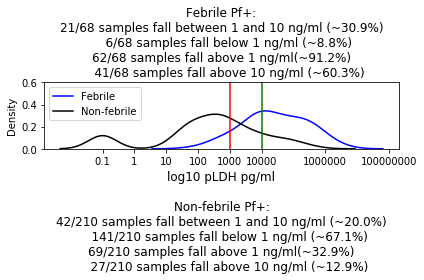

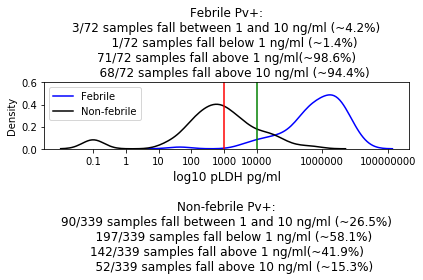

In [150]:
for feb_df, non_feb_df, species in [(feb_pf_df, non_feb_pf_df, 'Pf'), (feb_pv_df, non_feb_pv_df, 'Pv')]:
    x1 = feb_df['quansys_LDH_Pan_pg_ml'].values
    x2 = non_feb_df['quansys_LDH_Pan_pg_ml'].values
    
    sub = feb_df.loc[feb_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
    sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(10000)]
    sub_samps = sub['sample_id'].values
    sub = len(sub)
    below = len(feb_df.loc[feb_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)])
    above = len(feb_df.loc[feb_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)])
    ten_above = len(feb_df.loc[feb_df['quansys_LDH_Pan_pg_ml'] > np.log10(10000)])
    total = len(feb_df)

    title1 = '''Febrile {sp}+:\n{s}/{t} samples fall between 1 and 10 ng/ml (~{st}%)
    {b}/{t} samples fall below 1 ng/ml (~{bt}%)\n{a}/{t} samples fall above 1 ng/ml(~{at}%)
    {ta}/{t} samples fall above 10 ng/ml (~{tat}%)'''.format(sp=species, p=pdf_title, t=total, s=sub,
    st=np.round(100*(sub/total), 1), b=below, bt=np.round(100*(below/total), 1), a=above,
    at=np.round(100*(above/total), 1), ta=ten_above, tat=np.round(100*(ten_above/total), 1))
    
    sub = non_feb_df.loc[non_feb_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
    sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(10000)]
    sub_samps = sub['sample_id'].values
    sub = len(sub)
    below = len(non_feb_df.loc[non_feb_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)])
    above = len(non_feb_df.loc[non_feb_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)])
    ten_above = len(non_feb_df.loc[non_feb_df['quansys_LDH_Pan_pg_ml'] > np.log10(10000)])
    total = len(non_feb_df)

    title2 = '''log10 pLDH pg/ml\n\nNon-febrile {sp}+:\n{s}/{t} samples fall between 1 and 10 ng/ml (~{st}%)
    {b}/{t} samples fall below 1 ng/ml (~{bt}%)\n{a}/{t} samples fall above 1 ng/ml(~{at}%)
    {ta}/{t} samples fall above 10 ng/ml (~{tat}%)'''.format(sp=species, p=pdf_title, t=total, s=sub,
    st=np.round(100*(sub/total), 1), b=below, bt=np.round(100*(below/total), 1), a=above,
    at=np.round(100*(above/total), 1), ta=ten_above, tat=np.round(100*(ten_above/total), 1))
    
    pp = PdfPages('C:/Users/lzoeckler/Desktop/combined_{}.pdf'.format(species))
    ax = sns.distplot(x1, hist=False, color='b', label='Febrile')
    ax = sns.distplot(x2, hist=False, color='k', label='Non-febrile')
    ax.axvline(np.log10(1000), color='r')
    ax.axvline(np.log10(10000), color='g')
    ax.set_ylim(0, 0.6)
    ax.legend()
    ax.set_ylabel('Density')
    ax.set_xlabel(title2, fontsize=12)
    plt.xticks([-1, 0, 1, 2, 3, 4, 6, 8], [0.1, 1, 10, 100, 1000, 10000, 1000000, 100000000])
    f = ax.get_figure()
    plt.title(title1)
    plt.tight_layout()
    plt.show()
    pp.savefig(f)
    plt.close()
    pp.close()